# Copernicus Climate Change Service (C3S) - Upper Air Data Service 

    This IPython Notebook is intended for demonstration purposes and example usage of the Homogenization software for Radiosonde humidity data.
    For further information please refer to the Deliverable Document or the script `raso_adj_cdm_v0.py` on [Github CEUAS](https://github.com/MBlaschek/CEUAS/tree/master/CEUAS/public/adjust).

 Table of Contents:
* [Downloading of data](#Downloading-of-data)
* [Investigating the data](#Investigating-the-data)
* [Running the Homogenization software](#Running-the-Homogenization-software)
* [Investigating results](#Investigating-results)

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Plotting parameters
plt.rcParams['figure.figsize'] = [12.0, 6.0]
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.style.use('seaborn-colorblind')

In [3]:
#
# Make sure you have Python 3
#
from platform import python_version
if python_version()[0] != '3':
    print("Your Version:", python_version())
    raise RuntimeError("This Notebook requires Python 3")

# Downloading of data
For demonstration purposes, example data is allready available but we show here how to download these data from the CDS.

A typical request should contain:
1. **statid** - the Station Identifier
2. **date** - datetime selection YYYYMMDD
3. **pressure_level** - selection of pressure levels
4. **variable** - selection of variables 
5. **fbstats**  - feedback information from reanalysis

In [4]:
if True:
    import requests, zipfile, io
    #
    # This is for Python 3+
    #
    # http://early-upper-air.copernicus-climate.eu
    r = requests.post('http://srvx8.img.univie.ac.at:8004',
                      headers={'content-type': 'application/json'},
                      json={"statid": "72357",
                            "date": [19900101, 20181231],
                            "pressure_level": [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000,
                                               50000, 70000, 85000, 92500, 100000],
                            "variable": ["temperature", "relative_humidity"],
                            "fbstats": ["obs_minus_bg", "obs_minus_an", "bias_estimate"]
                            },
                      stream=True)
    if "Administrator" in r.text:
        print(r.text)
        raise RuntimeError("Something is not correct with the request")
    #
    # Unzip the Data Stream
    #
    try:
        z = zipfile.ZipFile(io.BytesIO(r.content))
        print("Retreived files: ")
        print(z.namelist())
        z.extractall(path='./example_data')
    except:
        print(r.text)
        print("Error in request")

Retreived files: 
['dest_72357_air_temperature.nc', 'dest_72357_relative_humidity.nc']


Another Way can be use a Linux tool called `curl` to download a zipfile:
```bash
curl -H "Content-Type: application/json" -X POST --digest --data '{"statid":"10393","date":[20000101,20181231],"pressure_level":[1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000],"variable":["temperature","relative_humidity"],"fbstats":["obs_minus_bg","obs_minus_an","bias_estimate"]}' -o example_data/download.zip http://srvx8.img.univie.ac.at:8004
```
and then unzip the contents in the directory
```bash
unzip -o example_data/download.zip
```

In [5]:
# Show the new downloaded files in example_data directory
!tree -Dhr

.
├── [1.0K Jan 15 17:01]  README.md
├── [ 37K Jan 24 11:26]  raso_adj_cdm_v0.py
├── [  43 Jan 24 11:27]  __pycache__
│   └── [ 24K Jan 24 11:27]  raso_adj_cdm_v0.cpython-37.pyc
├── [129K Jan 24 11:53]  Example_Homogenization.ipynb
└── [  80 Jan 24 11:53]  example_data
    ├── [5.4M Jan 24 11:53]  dest_72357_relative_humidity.nc
    └── [5.5M Jan 24 11:53]  dest_72357_air_temperature.nc

2 directories, 6 files


In [9]:
# Example output of retrieved NetCDF file
!ncdump -h example_data/dest_72357_air_temperature.nc

netcdf dest_72357_air_temperature {
dimensions:
	obs = 334367 ;
	string5 = 5 ;
	trajectory = 21329 ;
variables:
	float bias_estimate(obs) ;
		bias_estimate:cdmname = "era5fb/biascorr@body" ;
		bias_estimate:units = "K" ;
		bias_estimate:coordinates = "lat lon time plev" ;
		bias_estimate:cdsname = "bias_estimate" ;
		bias_estimate:standard_name = "air_temperature" ;
		bias_estimate:long_name = "ERA5 reanalysis bias_estimate" ;
	float lat(obs) ;
		lat:_FillValue = NaNf ;
		lat:description = "Latitude of the observed value, -90 to 90 (or other as defined by CRS)" ;
		lat:cdmname = "observations_table/latitude" ;
		lat:units = "degree_north" ;
		lat:standard_name = "latitude" ;
	float lon(obs) ;
		lon:_FillValue = NaNf ;
		lon:cdmname = "observations_table/longitude" ;
		lon:description = "Longitude of the observed value, -180 to 180 (or other as defined by CRS). This may or may not be the same as the report location." ;
		lon:units = "degree_east" ;
		lon:standard_name = "longitude" ;
	f

# Investigating the data
This is an example, but by the end of this contract, users will be delivered similar files.

The following shows how to open these files and read information. This are very common routines for data analysis.


In [15]:
import xarray as xr

In [23]:
ident = '72357'  # Station Identifier

In [31]:
tdata = xr.load_dataset('example_data/dest_{}_air_temperature.nc'.format(ident))

In [32]:
rdata = xr.load_dataset('example_data/dest_{}_relative_humidity.nc'.format(ident))

## Temperature data in Xarray

Notice that there are the following variables:
* bias_estimate - Reanalysis Bias estimate
* obs_min_an - Analysis Departures
* obs_min_bg - First Guess Departures
* ta - Observations
* trajectory_index - CDM Identifier
* trajectory_label - CDM Identifier

In [33]:
tdata

<xarray.Dataset>
Dimensions:           (obs: 334367, trajectory: 21329)
Coordinates:
    lat               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    lon               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    plev              (obs) float32 1000.0 2000.0 3000.0 ... 92500.0 100000.0
    time              (obs) datetime64[ns] 1989-03-28 1989-03-28 ... 1989-03-28
Dimensions without coordinates: obs, trajectory
Data variables:
    bias_estimate     (obs) float32 -1.340332 -0.295052 ... -0.02625 nan
    obs_minus_an      (obs) float32 0.280334 -2.471445 ... 1.084904 nan
    obs_minus_bg      (obs) float32 0.427206 -3.270976 -1.466765 ... 1.18198 nan
    ta                (obs) float32 219.3 214.3 213.3 ... 273.35 279.75 nan
    trajectory_index  (obs) int32 0 0 0 0 0 0 ... 21328 21328 21328 21328 21328
    trajectory_label  (trajectory) |S5 b'00551' b'00552' ... b'23679' b'23680'
Attributes:
    primary_id:    0-20000-0-72357
    station_name:  NORMAN

## Relative humidity 

In [27]:
rdata

<xarray.Dataset>
Dimensions:           (obs: 334367, trajectory: 21329)
Coordinates:
    lat               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    lon               (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    plev              (obs) float32 1000.0 2000.0 3000.0 ... 92500.0 100000.0
    time              (obs) datetime64[ns] 1989-03-28 1989-03-28 ... 1989-03-28
Dimensions without coordinates: obs, trajectory
Data variables:
    bias_estimate     (obs) float32 nan nan nan nan nan ... nan nan nan nan nan
    hur               (obs) float32 nan nan nan nan ... 0.838794 0.654979 nan
    obs_minus_an      (obs) float32 nan nan nan nan ... -0.054035 -0.091665 nan
    obs_minus_bg      (obs) float32 nan nan nan nan ... -0.050184 -0.050518 nan
    trajectory_index  (obs) int32 0 0 0 0 0 0 ... 21328 21328 21328 21328 21328
    trajectory_label  (trajectory) |S5 b'00551' b'00552' ... b'23679' b'23680'
Attributes:
    primary_id:    0-20000-0-72357
    stati

## Plotting

Text(0.5, 1.0, 'Radiosonde Temperature Observations from 72357 at 500 hPa')

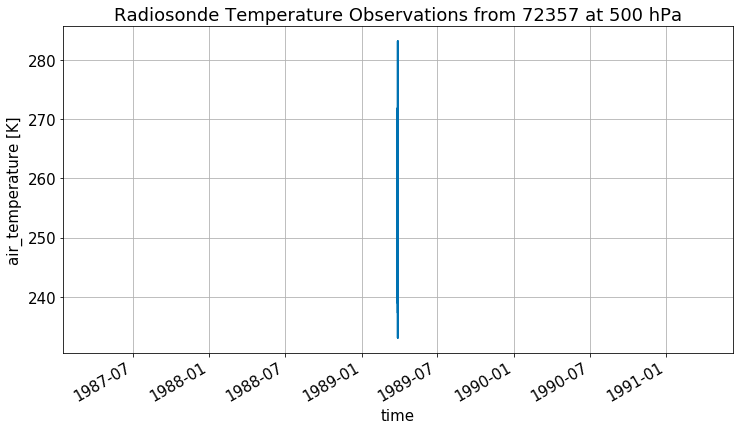

In [28]:
tdata.ta.sel(obs=(tdata.plev==50000)).swap_dims({'obs':'time'}).plot()
grid()
title("Radiosonde Temperature Observations from {} at 500 hPa".format(ident))

Text(0.5, 1.0, 'Radiosonde relative humidity Observations from 10393 at 500 hPa')

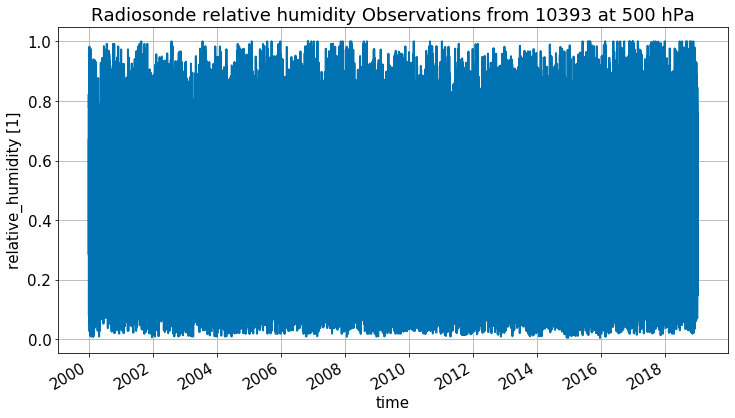

In [97]:
rdata.hur.sel(obs=(rdata.plev==50000)).swap_dims({'obs':'time'}).plot()
grid()
title("Radiosonde relative humidity Observations from {} at 500 hPa".format(ident))

# Running the Homogenization Software

The following steps are completed automatically within this script:
1. Read data and convert to datacubes [time x pressure]
2. Relative humidity 
3. Calculate test statistics
4. Detect breakpoints
5. Adjust timeseries
6. Write results

The Python script can also be run from the command line:
```bash
>>> python raso_adj_cdm_v0.py -h

Run standardized radiosonde homogenisation software on CDM compliant file

raso_adj_cdm_v0.py -h -f [file] -o [name] 

Options:
    -h              Help
    --help      
    -f []           Input CDM compliant file
    --file []       
    -o []           Output name
    --output []
    
Optional Keyword Options:
    --thres []      Threshold value for SNHT, default: 50

```

It is also possible to import the script like a module and execute some functions individually or the `main`.

## Import script as Module

In [26]:
import raso_adj_cdm_v0

In [32]:
import importlib as imp

In [223]:
imp.reload(raso_adj_cdm_v0)

<module 'raso_adj_cdm_v0' from '/raid8/srvx1/mblaschek/workspace/pybench/development/CEUAS/CEUAS/public/adjust/raso_adj_cdm_v0.py'>

### Usage information

In [ ]:
raso_adj_cdm_v0.usage()

### Execute Main

the `main` function needs to be called with string arguments, just like the script would do.
As described in the `usage` it requires inputdata (`'-f', "example_data/*.nc"`) and 
one Keyword-Option to return the data directly to the Notebook (`'--do-no-write'`).

The following steps will be done automatically:

    1. Read data
    2. Convert to time x pressure cubes
    3. Select only standard times (0, 12)
    4. Look for required variables
      4.1. Need observations and obs_minus_an
    5. Calculate test statistics
    6. Detect Breakpoints
    7. Calculate Adjustments
    8. Return/Write data

In [224]:
data = raso_adj_cdm_v0.main(ifile="example_data/*.nc", do-not-write=True, adddate=True)

[INFO] Multiple input files:  example_data/*.nc  | # 2
[INPUT] example_data/dest_10393_air_temperature.nc ta
[INPUT] example_data/dest_10393_relative_humidity.nc hur
[OUTPUT] example_data/dest_10393_relative_humidity_out.nc
[CONVERT] Converting to DataCube ...
[CONVERT] Done
[CONVERT] Standard time calculated, Duplicates resolved: 251
[CONVERT] Converting to day-night Array [hour x time x pressure]
[CHECK] Departures found ta obs_minus_an
[CHECK] Departures found ta bias_estimate
[CHECK] Departures found hur obs_minus_an
[CHECK] Departures found hur bias_estimate
[SNHT] Test statistics calculted ta_obs_minus_an_snht
[DETECT] Test statistics calculated ta_obs_minus_an_snht_breaks
[SNHT] Test statistics calculted hur_obs_minus_an_snht
[DETECT] Test statistics calculated hur_obs_minus_an_snht_breaks
[ADJUST] Breakpoints:  0
[ADJUST] Sample size: 10 N-Q: 13
[ADJUST] Breakpoints:  0
[ADJUST] Sample size: 10 N-Q: 13


In [225]:
# Print out Dataset
data

<xarray.Dataset>
Dimensions:                       (plev: 16, time: 27931)
Coordinates:
  * time                          (time) datetime64[ns] 2000-01-01T05:00:00 ... 2018-12-31T22:45:38
  * plev                          (plev) float64 1e+03 2e+03 ... 9.25e+04 1e+05
Data variables:
    ta_bias_estimate              (time, plev) float32 nan -0.08317 ... 0.0
    lat                           (time, plev) float32 nan nan nan ... nan nan
    lon                           (time, plev) float32 nan nan nan ... nan nan
    ta_obs_minus_an               (time, plev) float32 nan ... -0.036169
    ta_obs_minus_bg               (time, plev) float32 nan 0.733175 ... 0.347498
    ta                            (time, plev) float32 nan 201.7 ... 279.37
    hur_bias_estimate             (time, plev) float32 nan nan nan ... nan nan
    hur                           (time, plev) float32 nan nan nan ... 1.0 1.0
    hur_obs_minus_an              (time, plev) float32 nan nan ... 0.000384
    hur_obs_minus_

# Investigating results

## Departures

## SNHT

## Breakpoints

## Adjustments